In [12]:
import numpy as np
from matplotlib import pyplot as plt, rcParams
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.linear_model import LinearRegression, Lasso
from scipy.stats import wasserstein_distance

rcParams["figure.figsize"] = (8, 5)
rcParams["figure.dpi"] = 100
set_matplotlib_formats("retina")
plt.style.use("seaborn")

In [2]:
def do_corr(lnum, activations, targets):
    corrs = []
    for ind in range(activations.shape[2]):
        result = np.corrcoef(targets[:, 0], activations[:, lnum, ind])
        corrs.append(result[0, 1])
    return corrs

In [3]:
output = np.load("output.npz")

X_vals = output["activations"]
y = output["targets"]

In [4]:
corr = do_corr(48, X_vals, y)
rand_corr = do_corr(48, X_vals, np.random.uniform(0,2,(90,1)))

corr.sort()
rand_corr.sort()

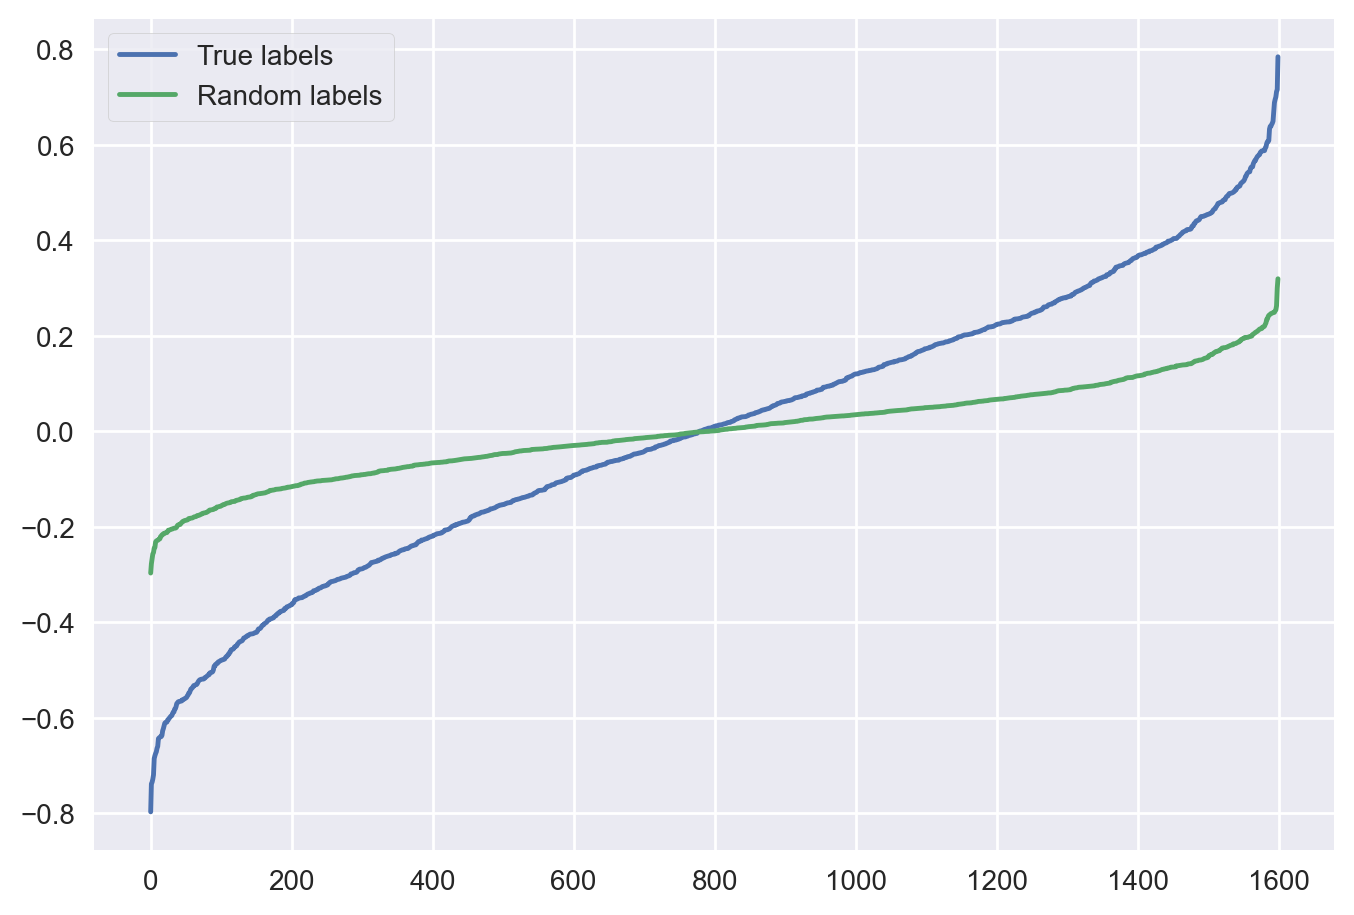

In [5]:
plt.plot(corr, label="True labels")
plt.plot(rand_corr, label="Random labels")
plt.legend(frameon=True)
plt.show()

In [6]:
corrs = []
rand_corrs = []
for l_num in range(49):
    corr = do_corr(l_num, X_vals, y)
    rand_corr = do_corr(l_num, X_vals, np.random.uniform(0,2,(90,1)))

    corr.sort()
    rand_corr.sort()

    corrs.append(corr)
    rand_corrs.append(rand_corr)

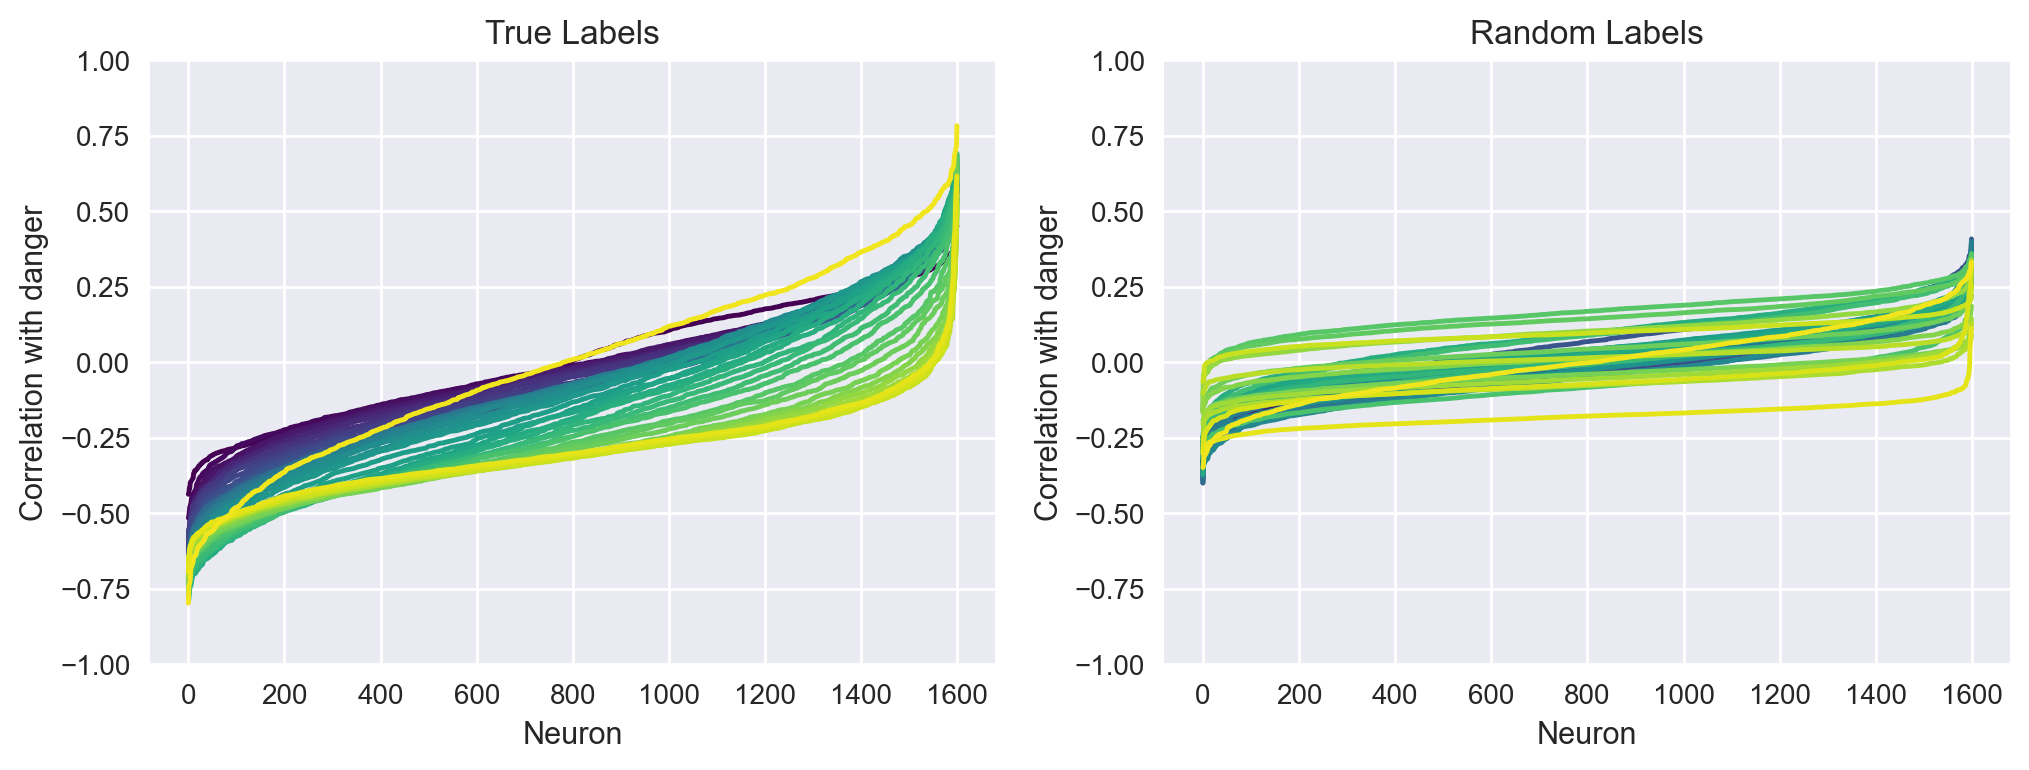

In [7]:
plt.figure(figsize=(12,4))

plt.subplot(121)
for l_num in range(49):
    c = corrs[l_num]
    plt.plot(c, color=plt.cm.viridis(l_num / 49))
plt.title('True Labels')
plt.xlabel("Neuron")
plt.ylabel("Correlation with danger")
plt.ylim([-1, 1])

plt.subplot(122)
for l_num in range(49):
    c = rand_corrs[l_num]
    plt.plot(c, color=plt.cm.viridis(l_num / 49))
plt.title('Random Labels')
plt.xlabel("Neuron")
plt.ylabel("Correlation with danger")
plt.ylim([-1, 1])

plt.show()

In [8]:
alpha_vals = [1, 5e-1, 2e-1, 1e-1, 5e-2, 2e-2, 1e-2]
r2_scores = []
coefs = []
n_coefs = []

for alpha in alpha_vals:
    model = Lasso(alpha=alpha)
    model.fit(X_vals[:, 48], y.squeeze())
    coefs.append(model.coef_)
    n_coefs.append(model.coef_[model.coef_ != 0].size)
    r2_scores.append(model.score(X_vals[:, 48], y.squeeze()))
    

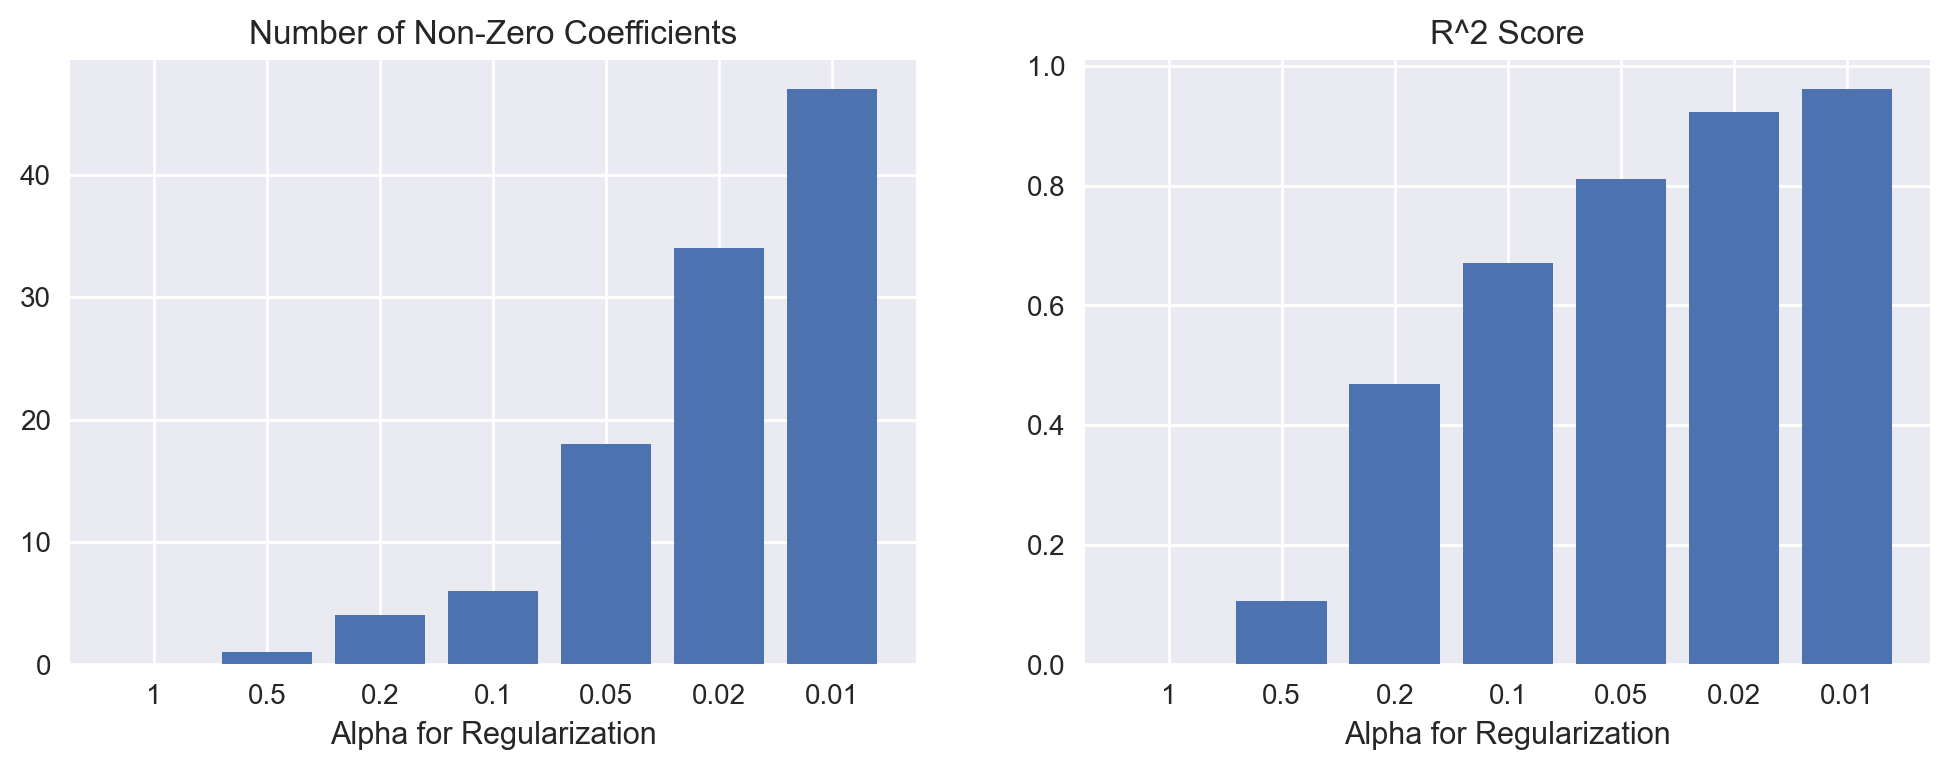

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.bar(x=list(map(str, alpha_vals)), height=n_coefs)
plt.title('Number of Non-Zero Coefficients')
plt.xlabel('Alpha for Regularization')

plt.subplot(122)
plt.bar(x=list(map(str, alpha_vals)), height=r2_scores)
plt.title('R^2 Score')
plt.xlabel('Alpha for Regularization')

plt.show()

In [10]:
layer_coefs = []
layer_r2_scores = []

for i in range(49):
    model = Lasso(alpha=0.5, max_iter=10000)
    model.fit(X_vals[:, i], y.squeeze())
    layer_coefs.append(model.coef_[model.coef_ != 0].size)
    layer_r2_scores.append(model.score(X_vals[:, i], y.squeeze()))

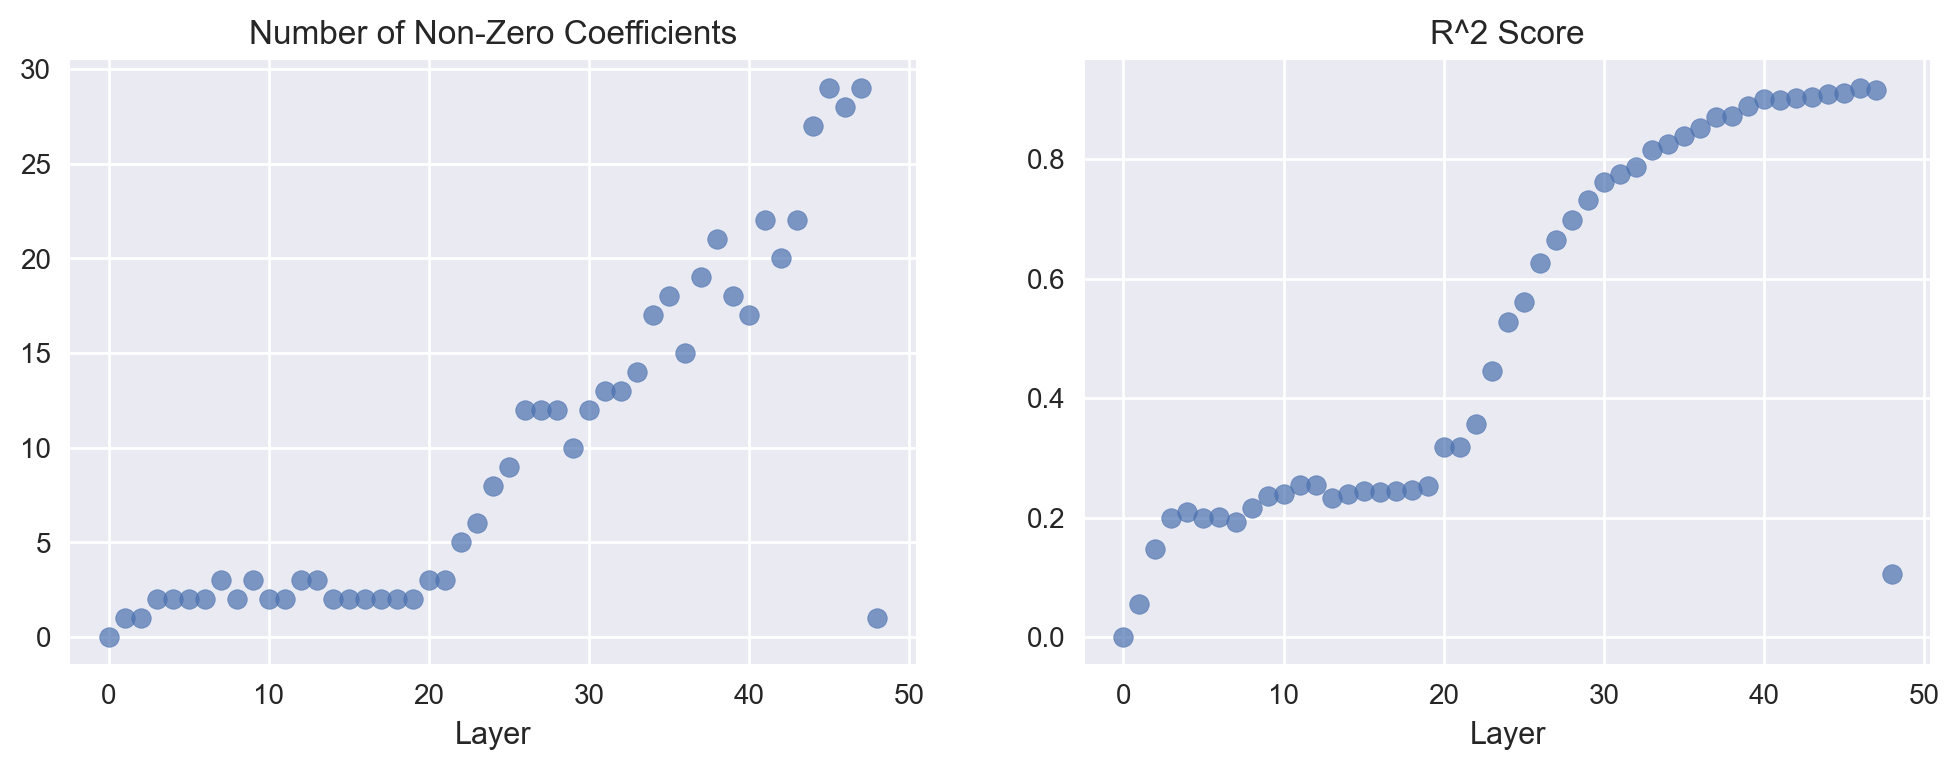

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.scatter(np.arange(49), layer_coefs, alpha=0.7)
plt.title('Number of Non-Zero Coefficients')
plt.xlabel('Layer')

plt.subplot(122)
plt.scatter(np.arange(49), layer_r2_scores, alpha=0.7)
plt.title('R^2 Score')
plt.xlabel('Layer')

plt.show()

# Wasserstein Distance Computation

In [13]:
X_vals.shape

(90, 49, 1600)

In [25]:
samples = X_vals.reshape(90, -1)
danger_mask = (y == 1).squeeze()
safe_mask = (y == 0).squeeze()
danger_samples = samples[danger_mask].T
safe_samples = samples[safe_mask].T

In [36]:
ws_distances = []
for danger_dist, safe_dist in zip(danger_samples, safe_samples):
    ws_distances.append(wasserstein_distance(danger_dist, safe_dist))
    
ws_distances = np.array(ws_distances)

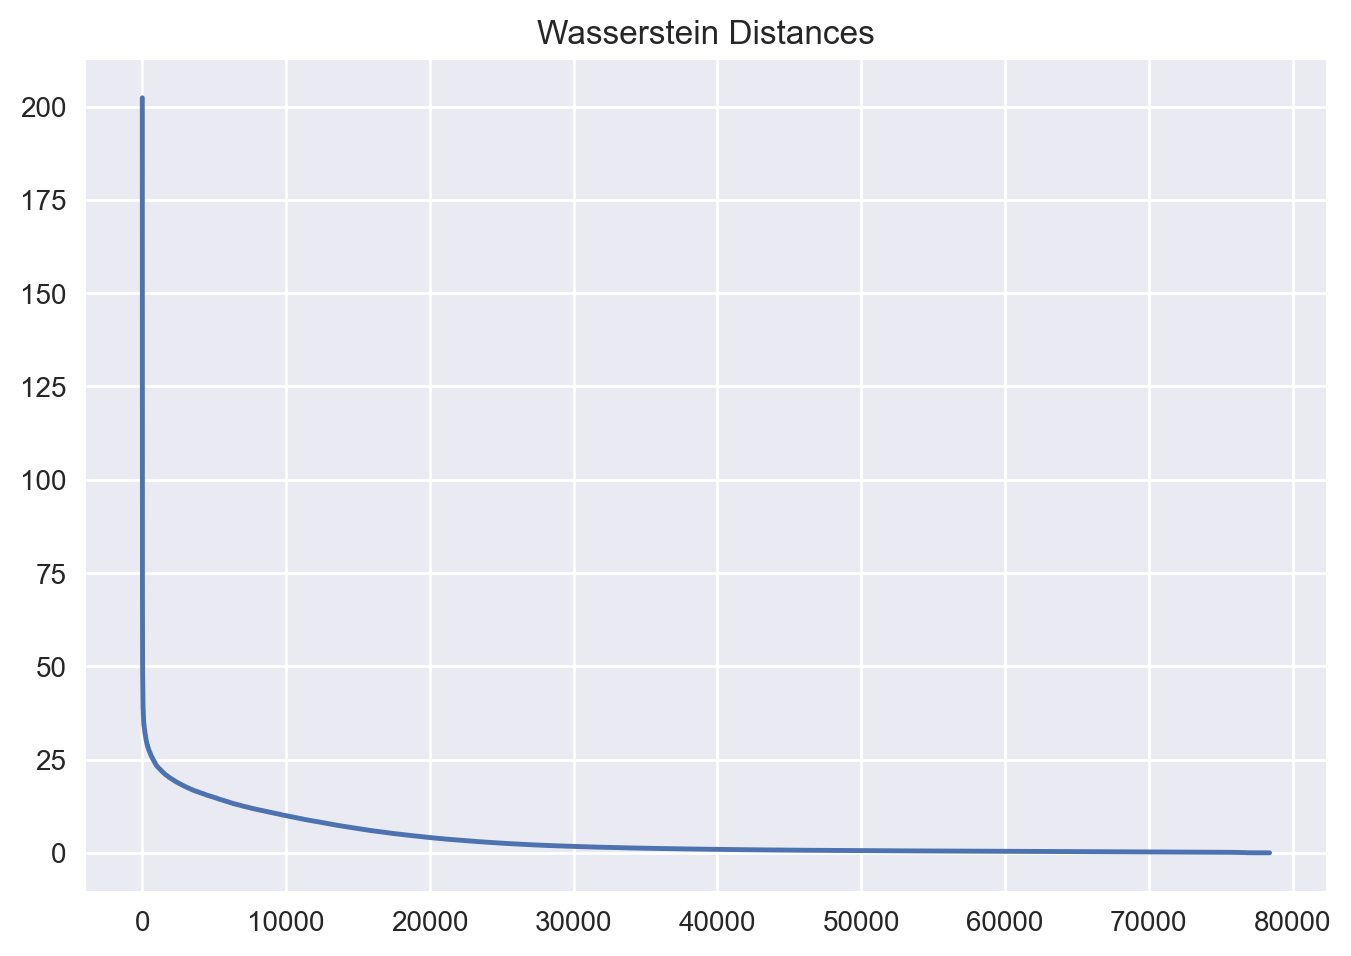

In [37]:
plt.plot(sorted(ws_distances)[::-1])
plt.title('Wasserstein Distances')
plt.show()

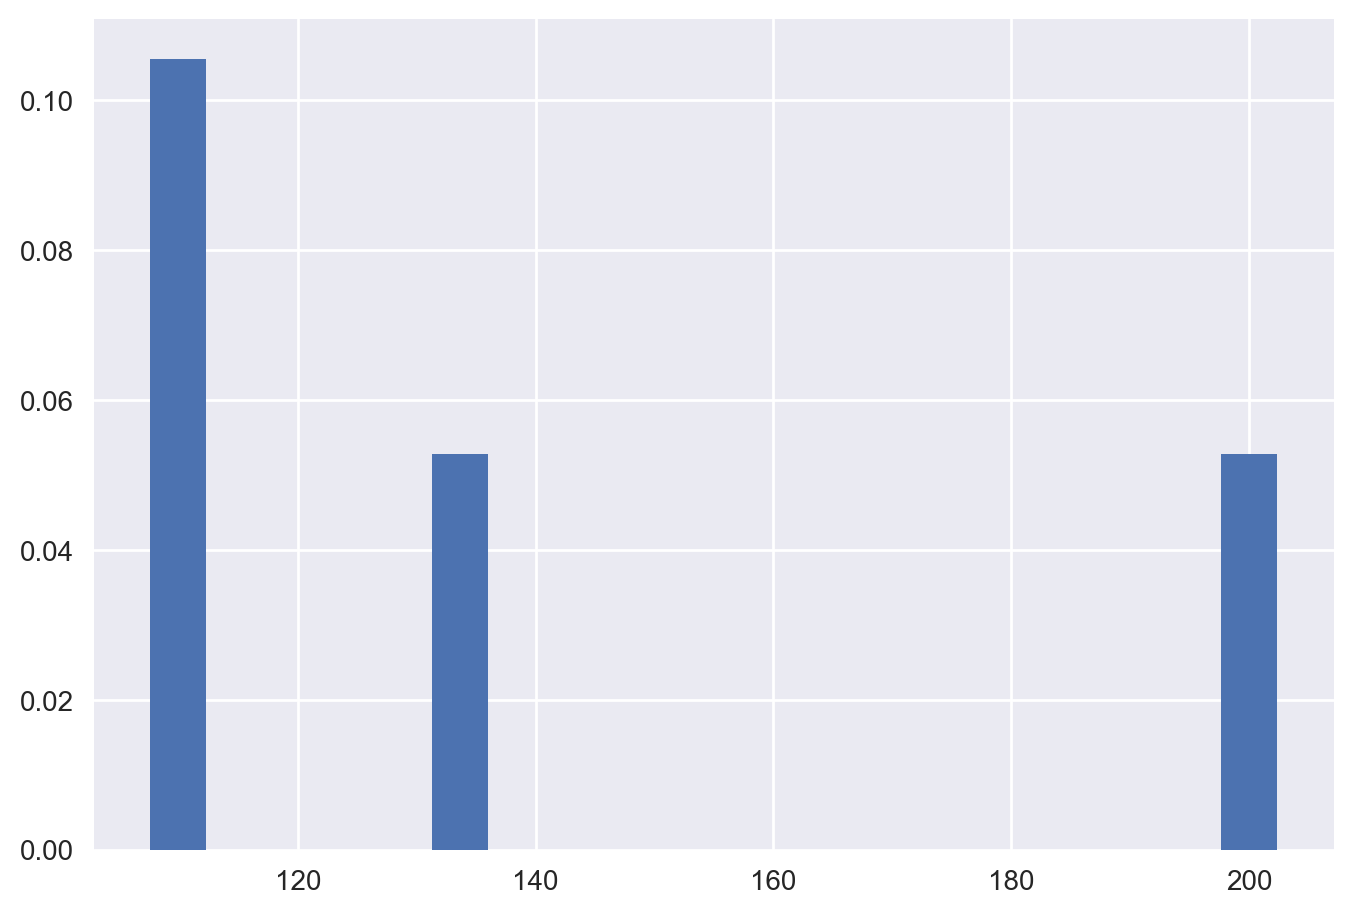

In [49]:
mask = ws_distances > 100
plt.hist(ws_distances[mask], bins=20, density=True)
plt.show()

In [54]:
ws_distances.reshape(-1, 1600).shape

(49, 1600)